<h2 style='color:blue' align='center'>Transfer learning in image classification</h2>

**In this notebook we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand**

In [4]:
# Install tensorflow_hub using pip install tensorflow_hub first

In [28]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Make predictions using ready made model (without any training)**

In [6]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

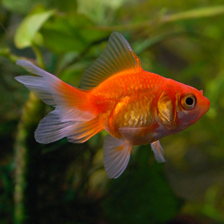

In [10]:
gold_fish = Image.open("/kaggle/input/goldfish/goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [11]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [15]:
gold_fish[np.newaxis, ...]

array([[[[0.28235294, 0.33333333, 0.07058824],
         [0.31372549, 0.37254902, 0.09019608],
         [0.34901961, 0.41960784, 0.11764706],
         ...,
         [0.32941176, 0.39215686, 0.00392157],
         [0.32156863, 0.38431373, 0.00392157],
         [0.30980392, 0.36862745, 0.        ]],

        [[0.28627451, 0.33333333, 0.08235294],
         [0.3254902 , 0.38039216, 0.10980392],
         [0.35294118, 0.42352941, 0.12941176],
         ...,
         [0.32156863, 0.38039216, 0.00392157],
         [0.31372549, 0.37254902, 0.00392157],
         [0.30196078, 0.36078431, 0.        ]],

        [[0.28627451, 0.33333333, 0.08627451],
         [0.31372549, 0.36862745, 0.10196078],
         [0.34509804, 0.41568627, 0.12941176],
         ...,
         [0.31764706, 0.37647059, 0.00392157],
         [0.30980392, 0.36862745, 0.00784314],
         [0.29803922, 0.35686275, 0.00392157]],

        ...,

        [[0.05490196, 0.10980392, 0.01568627],
         [0.05098039, 0.11372549, 0.01960784]

In [16]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

1/1 [==============================] - 0s 22ms/step


(1, 1001)

In [17]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [19]:
# tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
image_labels = []
with open("/kaggle/input/labels/ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [20]:
image_labels[predicted_label_index]

'goldfish'

<h3 style='color:purple'>Load flowers dataset</h3>

In [21]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228813984/228813984 [==============================] - 2s 0us/step


In [22]:
data_dir

'./datasets/flower_photos'

In [23]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [24]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/daisy/7630517248_98fb8bee1f_n.jpg'),
 PosixPath('datasets/flower_photos/daisy/5869147563_66fb88119d.jpg'),
 PosixPath('datasets/flower_photos/daisy/14399435971_ea5868c792.jpg'),
 PosixPath('datasets/flower_photos/daisy/5739768868_9f982684f9_n.jpg'),
 PosixPath('datasets/flower_photos/daisy/2578695910_5ab8ee17c1_n.jpg')]

In [25]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [26]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/4325834819_ab56661dcc_m.jpg'),
 PosixPath('datasets/flower_photos/roses/5799616059_0ffda02e54.jpg'),
 PosixPath('datasets/flower_photos/roses/15965652160_de91389965_m.jpg'),
 PosixPath('datasets/flower_photos/roses/4979895172_ca06eba616.jpg'),
 PosixPath('datasets/flower_photos/roses/15333843782_060cef3030.jpg')]

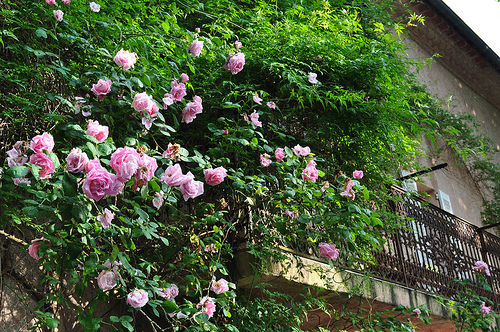

In [29]:
Image.open(str(roses[1]))

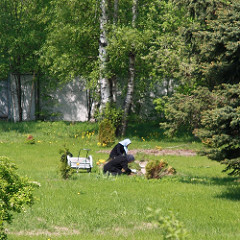

In [31]:
tulips = list(data_dir.glob('tulips/*'))
Image.open(str(tulips[0]))

<h3 style='color:purple'>Read flowers images from disk into numpy array using opencv</h3>

In [32]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

In [34]:
data_dir

'./datasets/flower_photos'

In [35]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [36]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/daisy/7630517248_98fb8bee1f_n.jpg'),
 PosixPath('datasets/flower_photos/daisy/5869147563_66fb88119d.jpg'),
 PosixPath('datasets/flower_photos/daisy/14399435971_ea5868c792.jpg'),
 PosixPath('datasets/flower_photos/daisy/5739768868_9f982684f9_n.jpg'),
 PosixPath('datasets/flower_photos/daisy/2578695910_5ab8ee17c1_n.jpg')]

In [37]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [38]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [39]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/4325834819_ab56661dcc_m.jpg'),
 PosixPath('datasets/flower_photos/roses/5799616059_0ffda02e54.jpg'),
 PosixPath('datasets/flower_photos/roses/15965652160_de91389965_m.jpg'),
 PosixPath('datasets/flower_photos/roses/4979895172_ca06eba616.jpg'),
 PosixPath('datasets/flower_photos/roses/15333843782_060cef3030.jpg')]

In [40]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/4325834819_ab56661dcc_m.jpg'

In [41]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [42]:
img.shape

(239, 240, 3)

In [43]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [44]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [45]:
X = np.array(X)
y = np.array(y)

<h3 style='color:purple'>Train test split</h3>

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<h3 style='color:purple'>Preprocessing: scale images</h3>

In [47]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Make prediction using pre-trained model on new flowers dataset**

In [48]:
X[0].shape

(224, 224, 3)

In [49]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [50]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

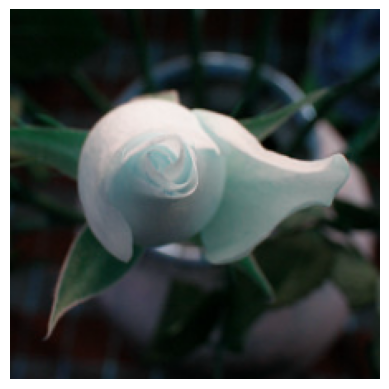

In [51]:
plt.axis('off')
plt.imshow(X[0])

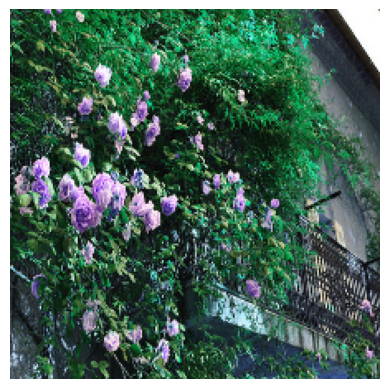

In [52]:
plt.axis('off')
plt.imshow(X[1])

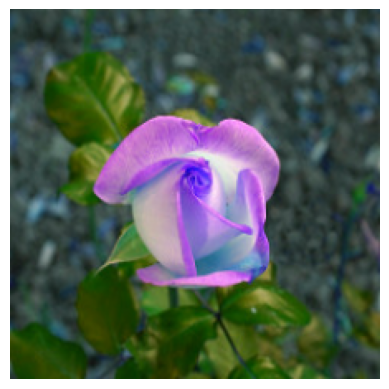

In [53]:
plt.axis('off')
plt.imshow(X[2])

In [54]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 1s 989ms/step


array([795, 795, 795])

In [55]:
image_labels[795]

'shower curtain'

<h3 style='color:purple'>Now take pre-trained model and retrain it using flowers images</h3>

In [56]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [57]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [58]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
 3/86 [>.............................] - ETA: 2s - loss: 1.8195 - acc: 0.1667  

I0000 00:00:1755051626.709634     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 [==============================] - 7s 28ms/step - loss: 0.7984 - acc: 0.6977
Epoch 2/5
86/86 [==============================] - 2s 28ms/step - loss: 0.4190 - acc: 0.8528
Epoch 3/5
86/86 [==============================] - 2s 28ms/step - loss: 0.3253 - acc: 0.8983
Epoch 4/5
86/86 [==============================] - 2s 28ms/step - loss: 0.2711 - acc: 0.9179
Epoch 5/5
86/86 [==============================] - 2s 27ms/step - loss: 0.2362 - acc: 0.9281


In [59]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 2s 53ms/step - loss: 0.3675 - acc: 0.8606


[0.367531418800354, 0.8605664372444153]